# This file is to extract RBP interactions from Protein-protein interaction networks

## STRING network
- the network is to be used for further validation

In [1]:
root_dir = '/home/hsher/seqdata/ppi/'

In [2]:
import pandas as pd
rbp_id = pd.read_pickle('RBP_id.pickle')

In [3]:
# load string
string = pd.read_csv(root_dir+'9606.protein.actions.v11.0.txt', sep = '\t', header = 0)

In [4]:
string.head()

,item_id_a,item_id_b,mode,action,is_directional,a_is_acting,score
0,9606.ENSP00000000233,9606.ENSP00000216366,binding,NaN,f,f,165
1,9606.ENSP00000000233,9606.ENSP00000216366,reaction,NaN,f,f,165
2,9606.ENSP00000000233,9606.ENSP00000216366,reaction,NaN,t,f,165
3,9606.ENSP00000000233,9606.ENSP00000216366,reaction,NaN,t,t,165
4,9606.ENSP00000000233,9606.ENSP00000222547,binding,NaN,f,f,913


In [5]:
string['protein_one'] = string['item_id_a'].str.replace('9606.', '')
string['protein_two'] = string['item_id_b'].str.replace('9606.', '')

In [6]:
all_rbp_esnp = set()
_ = [all_rbp_esnp.update(i) for i in rbp_id['esnp']]

In [7]:
len(all_rbp_esnp)

1176

# Links between RBP

In [8]:
string_subset = string.loc[(string['protein_one'].isin(all_rbp_esnp)) & (string['protein_two'].isin(all_rbp_esnp))]

In [9]:
string_subset.shape

(10524, 9)

In [10]:
esnp_in_string = set(string_subset['protein_one']).union(set(string_subset['protein_two']))
len(set(string_subset['protein_one']).union(set(string_subset['protein_two']))) # 118 RBP

118

In [11]:
rbp_id.shape #some RBP are not accounted

(150, 219)

In [12]:
string_subset['mode'].value_counts() # type of itxn

reaction      5126
catalysis     3162
binding       2056
activation     130
inhibition      48
expression       2
Name: mode, dtype: int64

In [13]:
rbp_id['esnp']

query
HNRNPC      {ENSP00000452599, ENSP00000452213, ENSP0000044...
RBFOX2      {ENSP00000474464, ENSP00000407855, ENSP0000047...
IGF2BP1                    {ENSP00000389135, ENSP00000290341}
HNRNPK      {ENSP00000409456, ENSP00000317788, ENSP0000047...
SRSF7       {ENSP00000408868, ENSP00000386806, ENSP0000039...
                                  ...                        
PRPF4                      {ENSP00000363313, ENSP00000363315}
TIAL1       {ENSP00000403573, ENSP00000358082, ENSP0000039...
DDX21                      {ENSP00000346120, ENSP00000480334}
APOBEC3C                   {ENSP00000355340, ENSP00000390855}
SUB1        {ENSP00000423893, ENSP00000422078, ENSP0000042...
Name: esnp, Length: 150, dtype: object

In [14]:
# map esnp back to name

# identify esnp
string_ensp = [(list(rbp_id['esnp'][i].intersection(esnp_in_string))[0],i) for i in rbp_id['esnp'].index if len(rbp_id['esnp'][i].intersection(esnp_in_string))>0]

In [15]:
string_subset['protein_one_rbp'] = string_subset['protein_one'].map(dict(string_ensp))
string_subset['protein_two_rbp'] = string_subset['protein_two'].map(dict(string_ensp))

/home/hsher/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/hsher/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
string_subset.to_pickle('string_rbp_in.pickle')

# Visualize string subset RBP networks

In [17]:
import networkx as nx
G = nx.convert_matrix.from_pandas_edgelist(string_subset, source='protein_one_rbp', target='protein_two_rbp')

In [18]:
nx.number_connected_components(G)

2

In [19]:
component_list = nx.connected_components(G) # a big one, and WRN+XRCC6

In [20]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(G))

In [21]:
[len(s) for s in c]

[55, 49, 9, 3, 2]

In [22]:
adj = nx.convert_matrix.to_pandas_adjacency(G)


In [23]:
module = pd.Series(index = adj.index)
colors = ['red','orange', 'gold', 'green', 'navy']
n=0
for community in c:
    module.loc[list(community)] = colors[n]
    n+=1

/home/hsher/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


/home/hsher/miniconda3/lib/python3.7/site-packages/seaborn/matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/hsher/miniconda3/lib/python3.7/site-packages/seaborn/matrix.py:595: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


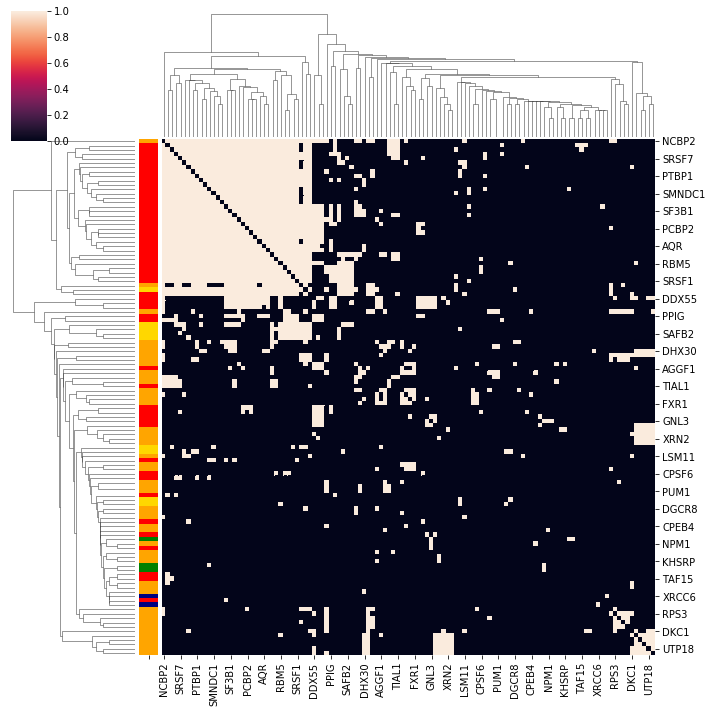

In [24]:
import seaborn as sns
sns.clustermap(adj, row_colors = module)

# Links between RBP and other protein

In [25]:
string_across = string.loc[(string['protein_one'].isin(all_rbp_esnp)) | (string['protein_two'].isin(all_rbp_esnp))]

In [26]:
string_across.shape

(148626, 9)

In [27]:
len((set(string_across['protein_one']).union(set(string_across['protein_two']))).intersection(all_rbp_esnp))
# some RBP don't have partners within RBPs but have other protein partners

145

In [28]:
RBP_partners = (set(string_across['protein_one']).union(set(string_across['protein_two'])))-set(all_rbp_esnp)

In [29]:
len(RBP_partners) # in total 2958 other proteins interact with our set of RBP

2958

# BioPlex 2020

In [30]:
# load string
bioplex = pd.read_csv(root_dir + 'BioPlex_293T_Network_10K_Dec_2019.tsv', sep = '\t', header = 0)

In [31]:
bioplex.head()

,GeneA,GeneB,UniprotA,UniprotB,SymbolA,SymbolB,pW,pNI,pInt
0,100,728378,P00813,A5A3E0,ADA,POTEF,6.881844e-10,0.000118,0.999882
1,222389,6137,Q8N7W2-2,P26373,BEND7,RPL13,1.340380e-18,0.225664,0.774336
2,222389,5928,Q8N7W2-2,Q09028-3,BEND7,RBBP4,7.221401e-21,0.000064,0.999936
3,222389,25873,Q8N7W2-2,Q9Y3U8,BEND7,RPL36,7.058372e-17,0.128183,0.871817
4,222389,6124,Q8N7W2-2,P36578,BEND7,RPL4,1.632313e-22,0.200638,0.799362


In [32]:
b1 = bioplex.loc[(bioplex['UniprotA'].isin(rbp_id['uniprot.Swiss-Prot'])) & (bioplex['UniprotB'].isin(rbp_id['uniprot.Swiss-Prot']))]

In [33]:
b2 = bioplex.loc[(bioplex['SymbolA'].isin(rbp_id.index)) & (bioplex['SymbolB'].isin(rbp_id.index))]

In [34]:
all_b = b1.append(b2)

In [35]:
all_b.drop_duplicates(inplace = True)

In [36]:
all_b.shape

(149, 9)

In [37]:
all_b.to_pickle('bioplex_rbp_in.pickle')

# BioGRID (include the HuRI)

In [38]:
# determine line of comment
with open(root_dir + 'BIOGRID-ORGANISM-Homo_sapiens-3.5.186.tab.txt') as f:
    i = 0
    for line in f.readlines():
        if line[:2] != 'ET':
            i += 1
        else:
            print(i)
            break
            

36


In [39]:
# load string
biogrid = pd.read_csv(root_dir + 'BIOGRID-ORGANISM-Homo_sapiens-3.5.186.tab.txt', sep = '\t', header = 0, skiprows = 35)

In [40]:
biogrid.head()

,INTERACTOR_A,INTERACTOR_B,OFFICIAL_SYMBOL_A,OFFICIAL_SYMBOL_B,ALIASES_FOR_A,ALIASES_FOR_B,EXPERIMENTAL_SYSTEM,SOURCE,PUBMED_ID,ORGANISM_A_ID,ORGANISM_B_ID
0,ETG6416,ETG2318,MAP2K4,FLNC,JNKK|JNKK1|MAPKK4|MEK4|MKK4|PRKMK4|SAPKK-1|SAP...,ABP-280|ABP280A|ABPA|ABPL|FLN2|MFM5|MPD4,Two-hybrid,Marti A (1997),9006895,9606,9606
1,ETG84665,ETG88,MYPN,ACTN2,CMD1DD|CMH22|MYOP|RCM4,CMD1AA,Two-hybrid,Bang ML (2001),11309420,9606,9606
2,ETG90,ETG2339,ACVR1,FNTA,ACTRI|ACVR1A|ACVRLK2|ALK2|FOP|SKR1|TSRI,FPTA|PGGT1A|PTAR2,Two-hybrid,Wang T (1996),8599089,9606,9606
3,ETG2624,ETG5371,GATA2,PML,DCML|IMD21|MONOMAC|NFE1B,MYL|PP8675|RNF71|TRIM19,Two-hybrid,Tsuzuki S (2000),10938104,9606,9606
4,RP4-547C9.3,ETG6774,RPA2,STAT3,REPA2|RP-A p32|RP-A p34|RPA32,ADMIO|APRF|HIES,Two-hybrid,Kim J (2000),10875894,9606,9606


In [41]:
biogrid_subset = biogrid.loc[(biogrid['OFFICIAL_SYMBOL_A'].isin(rbp_id.index)) & (biogrid['OFFICIAL_SYMBOL_B'].isin(rbp_id.index))]

In [42]:
biogrid_subset.shape

(1517, 11)

In [43]:
biogrid_subset.to_pickle('biogrid.pickle')

# Mentha

In [44]:
mentha = pd.read_csv(root_dir + '9606', sep = ';', header = 0)

In [45]:
mentha.shape

(340916, 6)

In [46]:
mentha.head()

,Protein A,Gene A,Protein B,Gene B,Score,PMID
0,Q9UBN7,HDAC6,Q9NQC7,CYLD,0.787,19893491 20593489
1,Q02078,MEF2A,P54198,HIRA,0.236,25609649
2,Q9UKX7,NUP50,Q9UBN7,HDAC6,0.236,23752268
3,Q9UBX3,SLC25A10,Q9UBN7,HDAC6,0.236,23752268
4,Q9UBN7,HDAC6,Q9NX61,TMEM161A,0.236,26496610


In [47]:
mentha_subset = mentha.loc[(mentha['Gene A'].isin(rbp_id.index)) & (mentha['Gene B'].isin(rbp_id.index))]

In [48]:
mentha_subset.shape

(599, 6)

In [49]:
mentha_subset.to_pickle('mentha.pickle')

# Corum complex

In [50]:
corum_complex = pd.read_csv(root_dir + 'allComplexes.txt', sep = '\t')

In [51]:
all_uniprot = set()
_ = [all_uniprot.update(ids) for ids in rbp_id['uniprot.Swiss-Prot'] if type(ids) != float]

In [52]:
selected_complex_index = []
i = 0
for complex_set in corum_complex['subunits(UniProt IDs)'].str.split(';').apply(set):
    if len(complex_set.intersection(all_uniprot))>0:
        selected_complex_index.append(i)
    i+= 1


In [53]:
corum_subset = corum_complex.loc[selected_complex_index]
corum_subset['composition'] = corum_subset['subunits(Gene name)'].str.split(';')

In [54]:
corum_subset.shape

(5, 21)

In [55]:
corum_subset.head()

,ComplexID,ComplexName,Organism,Synonyms,Cell line,subunits(UniProt IDs),subunits(Entrez IDs),Protein complex purification method,GO ID,GO description,...,FunCat description,subunits(Gene name),Subunits comment,PubMed ID,Complex comment,Disease comment,SWISSPROT organism,subunits(Gene name syn),subunits(Protein name),composition
314,351,Spliceosome,Human,U2-type spliceosome,None,O00425;O00571;O14776;O15042;O15355;O43143;O431...,10643;1654;10915;23350;5496;1665;9128;9092;912...,MI:0007- anti tag coimmunoprecipitation; MI:00...,GO:0008380;GO:0003723;GO:0005634,RNA splicing;RNA binding;nucleus,...,splicing;RNA binding;nucleus,IGF2BP3;DDX3X;TCERG1;U2SURP;PPM1G;DHX15;PRPF4;...,None,12226669,"In eukaryotes, the removal of introns from nas...",None,Homo sapiens (Human);Homo sapiens (Human);Homo...,IMP3 KOC1 VICKZ3;DBX DDX3;CA150 TAF2S;KIAA0332...,Insulin-like growth factor 2 mRNA-binding prot...,"[IGF2BP3, DDX3X, TCERG1, U2SURP, PPM1G, DHX15,..."
1061,1141,CF IIAm complex (Cleavage factor IIAm complex),Human,None,None,O43809;O60231;O94913;P19447;P23246;P26368;P265...,11051;8449;51585;2071;6421;11338;5725;4361;730...,MI:0226- ion exchange chromatography,GO:0031123;GO:0031124;GO:0005634,RNA 3'-end processing;mRNA 3'-end processing;n...,...,3'-end processing;nucleus,NUDT21;DHX16;PCF11;ERCC3;SFPQ;U2AF2;PTBP1;MRE1...,None,11060040,Eukaryotic mRNA precursors (pre-mRNAs) undergo...,None,Homo sapiens (Human);Homo sapiens (Human);Homo...,CFIM25 CPSF25 CPSF5;DBP2 DDX16 KIAA0577;KIAA08...,Cleavage and polyadenylation specificity facto...,"[NUDT21, DHX16, PCF11, ERCC3, SFPQ, U2AF2, PTB..."
1101,1181,C complex spliceosome,Human,None,None,O43290;O43390;O43660;O60306;O60506;O60508;O755...,9092;10236;5356;9716;10492;51362;23451;23020;2...,MI:0028- cosedimentation in solution; MI:0096-...,GO:0008380;GO:0003723;GO:0005634,RNA splicing;RNA binding;nucleus,...,splicing;RNA binding;nucleus,SART1;HNRNPR;PLRG1;AQR;SYNCRIP;CDC40;SF3B1;SNR...,None,11991638,"In eukaryotes, the removal of introns from nas...",None,Homo sapiens (Human);Homo sapiens (Human);Homo...,;HNRPR;;KIAA0560;HNRPQ NSAP1;EHB3 PRP17 PRPF17...,U4/U6.U5 tri-snRNP-associated protein 1 ;Heter...,"[SART1, HNRNPR, PLRG1, AQR, SYNCRIP, CDC40, SF..."
1781,2755,17S U2 snRNP,Human,None,None,O15042;O43143;O75533;O75937;O75940;P08579;P096...,23350;1665;23451;22826;10285;6629;6627;3329;66...,MI:0019- coimmunoprecipitation,GO:0008380;GO:0005634,RNA splicing;nucleus,...,splicing;nucleus,U2SURP;DHX15;SF3B1;DNAJC8;SMNDC1;SNRPB2;SNRPA1...,None,12234937,Spliceosome assembly is initiated by the inter...,None,Homo sapiens (Human);Homo sapiens (Human);Homo...,KIAA0332 SR140;DBP1 DDX15;SAP155;SPF31;SMNR SP...,U2 snRNP-associated SURP motif-containing prot...,"[U2SURP, DHX15, SF3B1, DNAJC8, SMNDC1, SNRPB2,..."
2067,3055,Nop56p-associated pre-rRNA complex,Human,Nop56p-associated pre-ribosomal ribonucleoprot...,None,O00567;O76021;P05141;P05386;P05387;P05388;P067...,10528;26156;292;6176;6181;6175;4869;6218;3178;...,MI:0007- anti tag coimmunoprecipitation; MI:00...,GO:0042254;GO:0005634,ribosome biogenesis;nucleus,...,ribosome biogenesis;nucleus,NOP56;RSL1D1;SLC25A5;RPLP1;RPLP2;RPLP0;NPM1;RP...,None,12777385,Identification of pre-rRNA species within hNop...,None,Homo sapiens (Human);Homo sapiens (Human);Homo...,NOL5A;CATX11 CSIG PBK1;ANT2;RRP1;D11S2243E RPP...,Nucleolar protein 56 ;Ribosomal L1 domain-cont...,"[NOP56, RSL1D1, SLC25A5, RPLP1, RPLP2, RPLP0, ..."


In [56]:
corum_subset.to_pickle('corum.pickle')

# ribosome

In [57]:
ribosome = pd.read_csv('protein_class_Ribosomal.tsv', header = 0, sep  = '\t')

In [58]:
ribosome.head()

,Gene,Gene synonym,Ensembl,Gene description,Uniprot,Chromosome,Position,Protein class,Biological process,Molecular function,...,Brain RNA - amygdala [NX],Brain RNA - basal ganglia [NX],Brain RNA - cerebellum [NX],Brain RNA - cerebral cortex [NX],Brain RNA - hippocampal formation [NX],Brain RNA - hypothalamus [NX],Brain RNA - midbrain [NX],Brain RNA - olfactory region [NX],Brain RNA - pons and medulla [NX],Brain RNA - thalamus [NX]
0,AURKAIP1,"AIP, AKIP, FLJ20608",ENSG00000175756,Aurora kinase A interacting protein 1,Q9NWT8,1,1373730-1375495,"Predicted intracellular proteins, Ribosomal pr...",NaN,"Ribonucleoprotein, Ribosomal protein",...,30.3,30.5,17.8,40.5,25.3,23.4,29.0,23.0,21.9,12.6
1,CHCHD1,"C10orf34, FLJ25854",ENSG00000172586,Coiled-coil-helix-coiled-coil-helix domain con...,Q96BP2,10,73782047-73783652,"Predicted intracellular proteins, Ribosomal pr...",NaN,"Ribonucleoprotein, Ribosomal protein",...,22.6,21.5,21.3,29.4,19.3,18.4,19.4,20.9,21.2,15.6
2,DAP3,"bMRP-10, DAP-3, DKFZp686G12159, MGC126058, MGC...",ENSG00000132676,Death associated protein 3,P51398,1,155687960-155739010,"Plasma proteins, Predicted intracellular prote...",Apoptosis,"Ribonucleoprotein, Ribosomal protein",...,22.9,25.9,19.5,23.6,27.0,26.4,24.9,23.0,23.0,21.1
3,FAU,"asr1, FLJ22986, Fub1, Fubi, MNSFbeta, RPS30, S30",ENSG00000149806,"FAU, ubiquitin like and ribosomal protein S30 ...","P35544, P62861",11,65120628-65122473,"Plasma proteins, Predicted intracellular prote...",NaN,"Ribonucleoprotein, Ribosomal protein",...,90.6,76.2,50.9,80.9,70.0,58.9,78.9,40.8,46.6,53.2
4,GADD45GIP1,"CKBBP2, CKbetaBP2, CRIF1, MGC4667, MGC4758, PL...",ENSG00000179271,GADD45G interacting protein 1,Q8TAE8,19,12953119-12957236,"Predicted intracellular proteins, Ribosomal pr...","Cell cycle, Host-virus interaction","Ribonucleoprotein, Ribosomal protein",...,32.7,29.1,17.2,29.1,26.4,27.6,26.0,23.6,17.7,17.1


In [59]:
rbp_id.loc[rbp_id['ensembl.gene'].isin(ribosome['Ensembl'])]

,HGNC,MIM,_id,_score,alias,entrezgene,exons,exons_hg19,generif,interpro,...,go.BP.pubmed,go.CC.evidence,go.CC.gocategory,go.CC.id,go.CC.pubmed,go.CC.term,reagent.CondMedia_CM_LibrAB.id,reagent.CondMedia_CM_LibrAB.relationship,esnp,esnt
query,,,,,,,,,,,,,,,,,,,,,
RPS3,10420,600454,6188,65.41434,S3,6188,"[{'cdsend': 75404865, 'cdsstart': 75399547, 'c...","[{'cdsend': 75115909, 'cdsstart': 75110591, 'c...","[{'pubmed': 11911468, 'text': 'Electron parama...","[{'desc': 'Ribosomal protein S3, C-terminal', ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{ENSP00000436556, ENSP00000435457, ENSP0000027...","{ENST00000528439, ENST00000529285, ENST0000052..."
RPS11,10384,180471,6205,66.05609,S11,6205,"[{'cdsend': 49499635, 'cdsstart': 49496456, 'c...","[{'cdsend': 50002892, 'cdsstart': 49999713, 'c...","[{'pubmed': 26506620, 'text': 'increased expre...","[{'desc': 'Ribosomal protein S17/S11', 'id': '...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{ENSP00000270625, ENSP00000471873, ENSP0000047...","{ENST00000599561, ENST00000594493, ENST0000060..."


# splicesome

In [60]:
splicesome = pd.read_csv('splicesome_proteins.csv', header = 0)

In [61]:
splicesome.head()

,Gene Symbol,Complex,Class / family,Full name from Entrez,More Aliases from Entrez,Organism,Ensemble Gene ID,Molecular weight from SwissProt,Domains from SwissProt,Motifs from SwissProt,Entrez Gene ID,Full Gene Name from Entrez,UniProt Entry Name,Other UniProt Accessions,Pdbs,Compositional AA Bias from SwissProt
0,SNRPB,"17S U2 snRNP, A complex, B complex, Bact compl...",Sm,small nuclear ribonucleoprotein polypeptides B...,"B polypeptide of Sm protein, Sm protein B/B', ...",H. sapiens,ENSG00000125835,24610,NaN,NaN,6628,small nuclear ribonucleoprotein polypeptides B...,RSMB_HUMAN,"P14678, Q15490, Q6IB35, Q9UIS5","1D3B, 2Y9A, 2Y9B, 2Y9C, 2Y9D",NaN
1,SNRPD1,"17S U2 snRNP, A complex, B complex, Bact compl...",Sm,small nuclear ribonucleoprotein D1 polypeptide...,"Sm-D autoantigen, small nuclear ribonucleoprot...",H. sapiens,ENSG00000167088,13282,NaN,NaN,6632,small nuclear ribonucleoprotein D1 polypeptide...,SMD1_HUMAN,"P62314, B5BTZ1, P13641","1B34, 2Y9A, 2Y9B, 2Y9C, 2Y9D",Arg/Lys-rich (basic)
2,SNRPD2,"17S U2 snRNP, A complex, B complex, Bact compl...",Sm,small nuclear ribonucleoprotein D2 polypeptide...,"small nuclear ribonucleoprotein Sm D2, snRNP c...",H. sapiens,ENSG00000125743,13527,NaN,NaN,6633,small nuclear ribonucleoprotein D2 polypeptide...,SMD2_HUMAN,"P62316, A8K797, P43330","1B34, 2Y9A, 2Y9B, 2Y9C, 2Y9D",NaN
3,SNRPD3,"17S U2 snRNP, A complex, B complex, Bact compl...",Sm,small nuclear ribonucleoprotein D3 polypeptide...,"small nuclear ribonucleoprotein Sm D3, small n...",H. sapiens,ENSG00000100028,13916,NaN,NaN,6634,small nuclear ribonucleoprotein D3 polypeptide...,SMD3_HUMAN,"P62318, B5BU13, P43331","1D3B, 2Y9A, 2Y9B, 2Y9C, 2Y9D",Arg/Lys-rich (basic)
4,SNRPE,"17S U2 snRNP, A complex, B complex, Bact compl...",Sm,small nuclear ribonucleoprotein polypeptide E,"sm protein E, small nuclear ribonucleoprotein ...",H. sapiens,ENSG00000182004,10804,NaN,NaN,6635,small nuclear ribonucleoprotein polypeptide E,RUXE_HUMAN,"P62304, B2R5B9, P08578, Q15498, Q5BKT2","2Y9A, 2Y9B, 2Y9C, 2Y9D, 3CW1",NaN


In [62]:
all_splice_complex = set()
_ = [all_splice_complex.update(s) for s in splicesome['Complex'].str.split(', ') if type(s) == list]

In [63]:
all_splice_complex

{'17S U2 snRNP',
 'A complex',
 'B complex',
 'Bact complex',
 'C complex',
 'P complex',
 'U1 snRNP',
 'U4/U6 snRNP',
 'U5 snRNP',
 'tri-snRNP'}

## Splicesome annotations are different

In [64]:
u2 = splicesome.loc[(splicesome['Complex'].notnull()) & (splicesome['Complex'].str.contains('17S U2 snRN'))]

In [65]:
u2.shape

(22, 16)

In [66]:
len(corum_subset.loc[1781, 'composition'])

33

In [67]:
set(u2['Gene Symbol']) - set(corum_subset.loc[1781, 'composition'])

{'HTATSF1', 'RNU2-1'}

## extract everything from spliceomse by complex

In [68]:
splice_dict = {}
for c in list(all_splice_complex):
    composition = splicesome.loc[(splicesome['Complex'].notnull()) & (splicesome['Complex'].str.contains(c)), 'Gene Symbol']
    splice_dict[c] = ';'.join(list(composition))
    

In [69]:
pd.DataFrame.from_dict(splice_dict, orient = 'index')

,0
A complex,SNRPB;SNRPD1;SNRPD2;SNRPD3;SNRPE;SNRPF;SNRPG;R...
U4/U6 snRNP,SNRPB;SNRPD1;SNRPD2;SNRPD3;SNRPE;SNRPF;SNRPG;R...
U1 snRNP,SNRPB;SNRPD1;SNRPD2;SNRPD3;SNRPE;SNRPF;SNRPG;R...
C complex,SNRPB;SNRPD1;SNRPD2;SNRPD3;SNRPE;SNRPF;SNRPG;R...
U5 snRNP,SNRPB;SNRPD1;SNRPD2;SNRPD3;SNRPE;SNRPF;SNRPG;R...
Bact complex,SNRPB;SNRPD1;SNRPD2;SNRPD3;SNRPE;SNRPF;SNRPG;R...
P complex,SNRPB;SNRPD1;SNRPD2;SNRPD3;SNRPE;SNRPF;SNRPG;R...
17S U2 snRNP,SNRPB;SNRPD1;SNRPD2;SNRPD3;SNRPE;SNRPF;SNRPG;R...
tri-snRNP,SNRPB;SNRPD1;SNRPD2;SNRPD3;SNRPE;SNRPF;SNRPG;R...
B complex,SNRPB;SNRPD1;SNRPD2;SNRPD3;SNRPE;SNRPF;SNRPG;R...
